# Using TensorBoard with PyTorch
## Before You Start

To run this tutorial, you'll need to install PyTorch, TorchVision, Matplotlib, and TensorBoard.

With `conda`:

```
conda install pytorch torchvision -c pytorch
conda install matplotlib tensorboard
```

With `pip`:

```
pip install torch torchvision matplotlib tensorboard
```

Once the dependencies are installed, restart this notebook in the Python environment where you installed them.

## Introduction

In this notebook, we'll be training a variant of LeNet-5 against the Fashion-MNIST dataset. Fashion-MNIST is a set of image tiles depicting various garments, with ten class labels indicating the type of garment depicted.

In [1]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

## Showing Images in TensorBoard

Let's start by adding sample images from our dataset to TensorBoard:

In [2]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [3]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

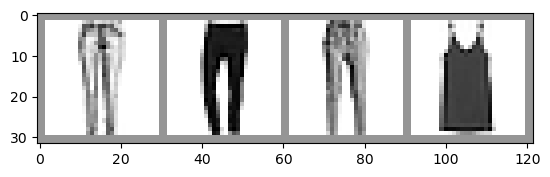

In [4]:
# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

Above, we used TorchVision and Matplotlib to create a visual grid of a minibatch of our input data. Below, we use the `add_image()` call on `SummaryWriter` to log the image for consumption by TensorBoard, and we also call `flush()` to make sure it's written to disk right away.

In [5]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

If you start TensorBoard at the command line and open it in a new browser tab (usually at [localhost:6006](localhost:6006)), you should see the image grid under the IMAGES tab.

## Graphing Scalars to Visualize Training

TensorBoard is useful for tracking the progress and efficacy of your training. Below, we'll run a training loop, track some metrics, and save the data for TensorBoard's consumption.

Let's define a model to categorize our image tiles, and an optimizer and loss function for training:

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Now let's train a single epoch, and evaluate the training vs. validation set losses every 1000 batches:

In [7]:
print(len(validation_loader))
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0
            
            net.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Turn gradients back on for training
            
            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)
            
            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


Switch to your open TensorBoard and have a look at the SCALARS tab.

## Visualizing Your Model
TensorBoard can also be used to examine the data flow within your model. To do this, call the `add_graph()` method with a model and sample input. When you open 

In [8]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

When you switch over to TensorBoard, you should see a GRAPHS tab. Double-click the "NET" node to see the layers and data flow within your model.

## Visualizing Your Dataset with Embeddings

The 28-by-28 image tiles we're using can be modeled as 784-dimensional vectors (28 * 28 = 784). It can be instructive to project this to a lower-dimensional representation. The `add_embedding()` method will project a set of data onto the three dimensions with highest variance, and display them as an interactive 3D chart. The `add_embedding()` method does this automatically by projecting to the three dimensions with highest variance.

Below, we'll take a sample of our data, and generate such an embedding:

In [9]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()
writer.close()

Now if you switch to TensorBoard and select the PROJECTOR tab, you should see a 3D representation of the projection. You can rotate and zoom the model. Examine it at large and small scales, and see whether you can spot patterns in the projected data and the clustering of labels.

**Note:** For better visibility, it's recommended to:
* Select "label" from the "Color by" drop-down on the left
* Toggle the Night Mode icon along the top to place the light-colored images on a dark background.

## Other Resources

For more information, have a look at:
* [PyTorch documentation on `torch.utils.tensorboard.SummaryWriter`](https://pytorch.org/docs/stable/tensorboard.html?highlight=summarywriter) on [PyTorch.org](https://pytorch.org)
* Tensorboard tutorial content in the [PyTorch.org Tutorials](https://pytorch.org/tutorials/)
* For more information about TensorBoard, see the [TensorBoard documentation](https://www.tensorflow.org/tensorboard)